# Imports

In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform

%matplotlib notebook
rng = np.random.RandomState(42)

# Functions

In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-40, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(np.abs(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Load data

## Load swiss data

In [6]:
gen = pd.read_excel('resources/data/Gen2Phen_GenotypeMatrix_for_Amit_and_betalactamases_list.xlsx', set_index='Isolate')
phen = pd.read_excel('resources/data/Gen2Phen_Phenotype_klebsiella_mic.xlsx', set_index="Isolate")
gen_full = pd.read_csv('resources/data/801532-18.abri.card.1.1.tsv', sep='\t')

## Exploration

### Genotype

In [327]:
list(gen.columns)

['Isolate',
 'AAC(3)-IId',
 'AAC(3)-IIe',
 "AAC(6')-Im",
 'APH(4)-Ia',
 'APH(6)-Id',
 'FosA5',
 'FosA7',
 'oqxA',
 'oqxB',
 'Escherichia_coli_ampC',
 'CTX-M-1',
 'CTX-M-14',
 'CTX-M-15',
 'CTX-M-9',
 'DHA-1',
 'OXA-1',
 'SHV-1',
 'TEM-1',
 'floR',
 "AAC(2')-IIa",
 "AAC(2')-IIb",
 "AAC(2')-Ia",
 "AAC(2')-Ib",
 "AAC(2')-Ic",
 "AAC(2')-Id",
 "AAC(2')-Ie",
 'AAC(3)-IIIa',
 'AAC(3)-IIIb',
 'AAC(3)-IIIc',
 'AAC(3)-IIa',
 'AAC(3)-IIb',
 'AAC(3)-IIc',
 'AAC(3)-IV',
 'AAC(3)-IXa',
 'AAC(3)-Ia',
 'AAC(3)-Ib',
 "AAC(3)-Ib/AAC(6')-Ib''",
 'AAC(3)-Ic',
 'AAC(3)-Id',
 'AAC(3)-VIIIa',
 'AAC(3)-VIIa',
 'AAC(3)-VIa',
 'AAC(3)-Xa',
 "AAC(6')-29a",
 "AAC(6')-29b",
 "AAC(6')-30/AAC(6')-Ib'_fusion_protein",
 "AAC(6')-31",
 "AAC(6')-32",
 "AAC(6')-33",
 "AAC(6')-34",
 "AAC(6')-I30",
 "AAC(6')-IIa",
 "AAC(6')-IIb",
 "AAC(6')-IIc",
 "AAC(6')-Ia",
 "AAC(6')-Iaa",
 "AAC(6')-Iad",
 "AAC(6')-Iae",
 "AAC(6')-Iaf",
 "AAC(6')-Iag",
 "AAC(6')-Iai",
 "AAC(6')-Iaj",
 "AAC(6')-Iak",
 "AAC(6')-Ian",
 "AAC(6')-Ib",
 "AAC(

In [70]:
gen.describe()

,Isolate,AAC(3)-IId,AAC(3)-IIe,AAC(6')-Im,APH(4)-Ia,APH(6)-Id,FosA5,FosA7,oqxA,oqxB,...,vgaB,vgaC,vgaD,vgaE,viomycin_phosphotransferase,vmlR,y56_beta-lactamase,ykkC,ykkD,yojI
count,143,143,143,143,143,143,143,143,143,143,...,143,143,143,143,143,143,143,143,143,143
unique,143,3,3,2,2,2,4,4,2,5,...,1,1,1,1,1,1,1,1,1,1
top,805666-18,.,.,.,.,100,.,.,100,100,...,.,.,.,.,.,.,.,.,.,.
freq,1,133,109,141,137,87,107,135,138,132,...,143,143,143,143,143,143,143,143,143,143


#### columns Importance

In [71]:
gen_des = gen.describe()
len(gen_des.columns[gen_des.loc['unique'] != 1])

20

In [72]:
gen_des.columns[gen_des.loc['unique'] != 1]

Index(['Isolate', 'AAC(3)-IId', 'AAC(3)-IIe', 'AAC(6')-Im', 'APH(4)-Ia',
       'APH(6)-Id', 'FosA5', 'FosA7', 'oqxA', 'oqxB', 'Escherichia_coli_ampC',
       'CTX-M-1', 'CTX-M-14', 'CTX-M-15', 'CTX-M-9', 'DHA-1', 'OXA-1', 'SHV-1',
       'TEM-1', 'floR'],
      dtype='object')

In [73]:
meaningfull_features = list(gen_des.columns[gen_des.loc['unique'] != 1])

In [328]:
gen_des.loc['top'][gen_des.loc['unique'] == 1]

AAC(2')-IIa                                                                     .
AAC(2')-IIb                                                                     .
AAC(2')-Ia                                                                      .
AAC(2')-Ib                                                                      .
AAC(2')-Ic                                                                      .
AAC(2')-Id                                                                      .
AAC(2')-Ie                                                                      .
AAC(3)-IIIa                                                                     .
AAC(3)-IIIb                                                                     .
AAC(3)-IIIc                                                                     .
AAC(3)-IIa                                                                      .
AAC(3)-IIb                                                                      .
AAC(3)-IIc      

#### explore values

In [329]:
gen.head()

,Isolate,AAC(3)-IId,AAC(3)-IIe,AAC(6')-Im,APH(4)-Ia,APH(6)-Id,FosA5,FosA7,oqxA,oqxB,...,vgaB,vgaC,vgaD,vgaE,viomycin_phosphotransferase,vmlR,y56_beta-lactamase,ykkC,ykkD,yojI
0,100548-2-19,.,.,.,.,.,100,.,100,100,...,.,.,.,.,.,.,.,.,.,.
1,121261-18,.,.,.,.,100,.,.,100,100,...,.,.,.,.,.,.,.,.,.,.
2,127940-19,.,.,.,.,.,100,.,100,100,...,.,.,.,.,.,.,.,.,.,.
3,130765-18,.,.,.,.,.,.,.,100,100,...,.,.,.,.,.,.,.,.,.,.
4,138096-18,.,.,.,.,100,.,.,100,100,...,.,.,.,.,.,.,.,.,.,.


In [330]:
pd.set_option('display.max_rows', None)
gen.iloc[:, [0,2,2000]]

,Isolate,AAC(3)-IIe,TEM-63
0,100548-2-19,.,.
1,121261-18,.,.
2,127940-19,.,.
3,130765-18,.,.
4,138096-18,.,.
5,145605-17,100,.
6,402121-18,.,.
7,500122-18,.,.
8,500888-12,.,.
9,500965-13,.,.


### Phenotype

In [11]:
phen.columns

Index(['strain', 'germ', 'Amoxicillin - Clavulanic acid', 'Amikacin',
       'Ampicillin / Amoxicillin', 'Cefepime', 'Ciprofloxacin', 'Cefpodoxim',
       'Colistin ', 'Ceftriaxon', 'Ceftazidim', 'Cefuroxim',
       'Cefuroxim-Axetil', 'Ertapenem', 'Fosfomycin-Trometamol', 'Gentamicin',
       'Imipenem', 'Levofloxacin', 'Meropenem', 'Nitrofurantoin',
       'Norfloxacin', 'Piperacillin-Tazobactam', 'Cotrimoxazol', 'Tetracyclin',
       'Tobramycin'],
      dtype='object')

In [12]:
phen.describe()

,Cefuroxim,Cefuroxim-Axetil,Levofloxacin,Tetracyclin
count,3.000000,5.000000,142.0,2.000000
mean,12.000000,10.400000,0.0,6.000000
std,6.928203,13.740451,0.0,2.828427
min,4.000000,0.000000,0.0,4.000000
25%,10.000000,0.000000,0.0,5.000000
50%,16.000000,4.000000,0.0,6.000000
75%,16.000000,16.000000,0.0,7.000000
max,16.000000,32.000000,0.0,8.000000


In [13]:
phen.head()

,strain,germ,Amoxicillin - Clavulanic acid,Amikacin,Ampicillin / Amoxicillin,Cefepime,Ciprofloxacin,Cefpodoxim,Colistin,Ceftriaxon,...,Gentamicin,Imipenem,Levofloxacin,Meropenem,Nitrofurantoin,Norfloxacin,Piperacillin-Tazobactam,Cotrimoxazol,Tetracyclin,Tobramycin
0,100548-2-19,klevar,<=2,<=2,16,<=1,<=.25,0,<=.5,<=1,...,NaN,<=.25,0.0,<=.25,0,0,2,<=20,NaN,<=1
1,121261-18,klepnee,16,<=2,>=32,2,>=4,0,<=.5,>=64,...,NaN,<=.25,0.0,<=.25,0,0,8,>=320,NaN,8
2,127940-19,klepne,4,<=2,>=32,<=1,<=.25,0,<=.5,<=1,...,NaN,<=.25,0.0,<=.25,0,0,3,<=20,NaN,<=1
3,130765-18,klepnee,4,<=2,>=32,<=1,1,0,<=.5,8,...,NaN,<=.25,0.0,<=.25,0,0,2,>=320,NaN,<=1
4,138096-18,klepnee,4,<=2,>=32,2,1,0,<=.5,>=64,...,NaN,<=.25,0.0,<=.25,0,0,3,40,NaN,<=1


<IPython.core.display.Javascript object>


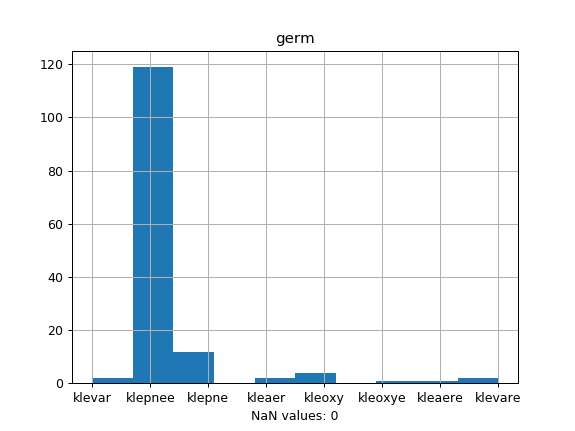

<IPython.core.display.Javascript object>


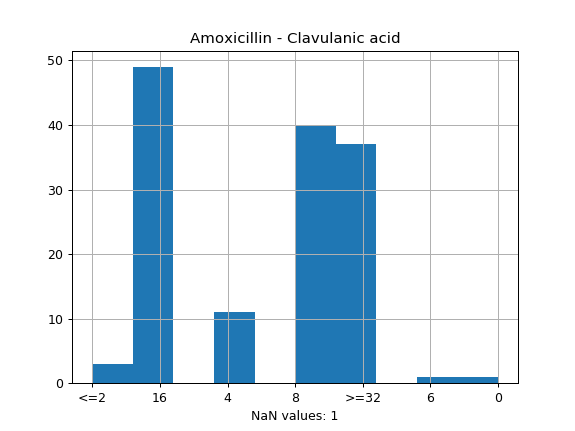

<IPython.core.display.Javascript object>


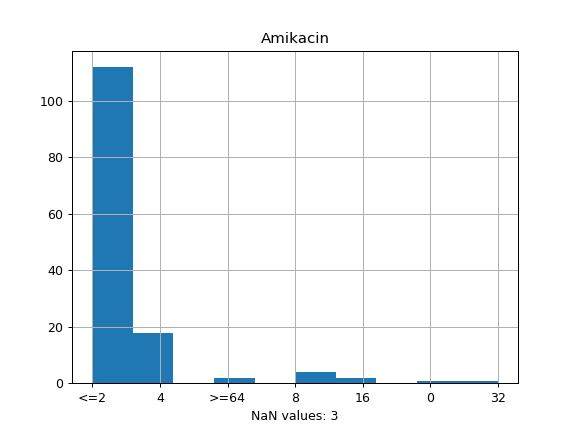

<IPython.core.display.Javascript object>


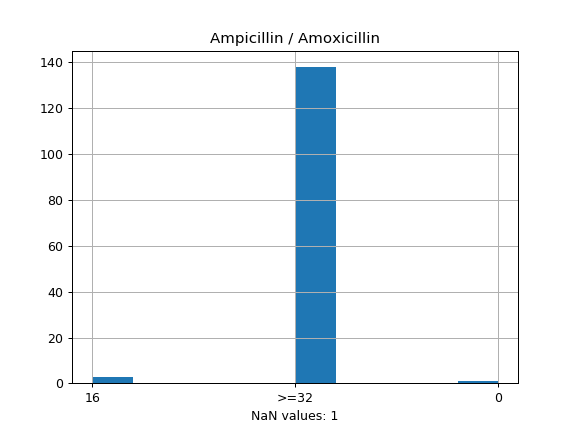

<IPython.core.display.Javascript object>


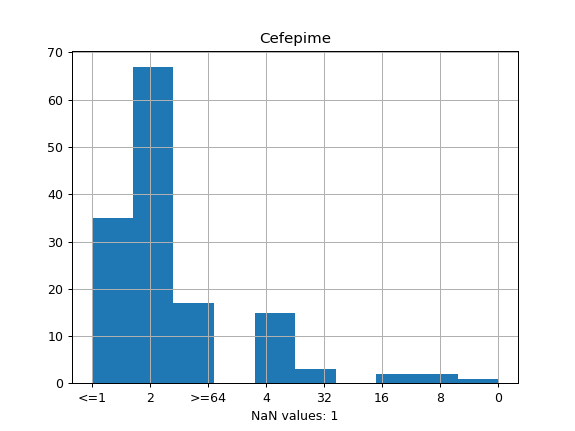

<IPython.core.display.Javascript object>


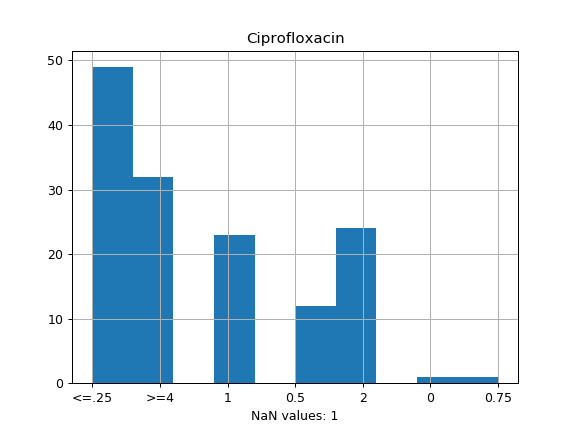

<IPython.core.display.Javascript object>


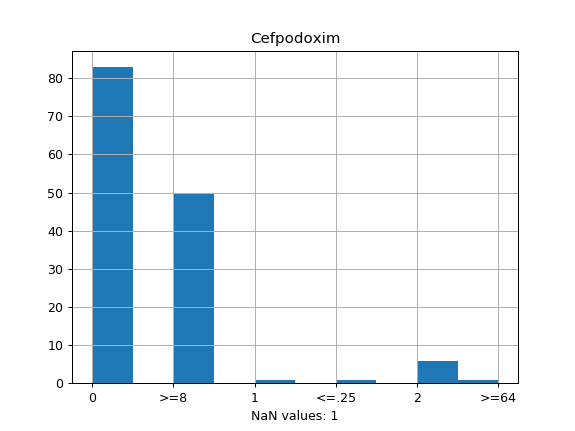

<IPython.core.display.Javascript object>


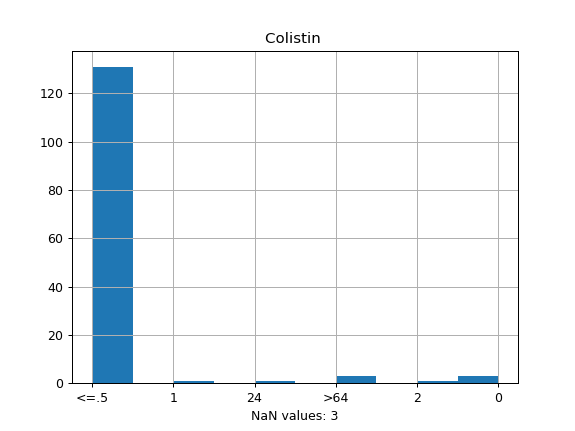

<IPython.core.display.Javascript object>


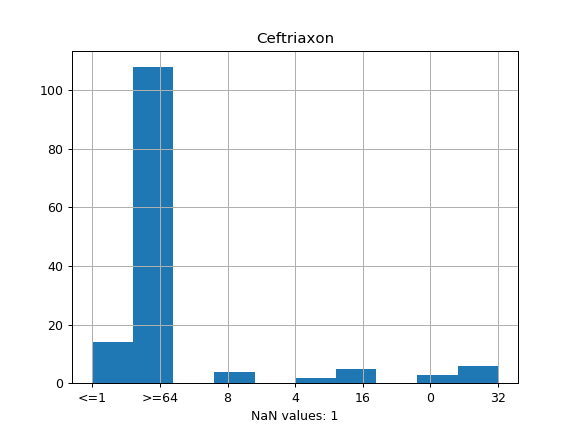

<IPython.core.display.Javascript object>


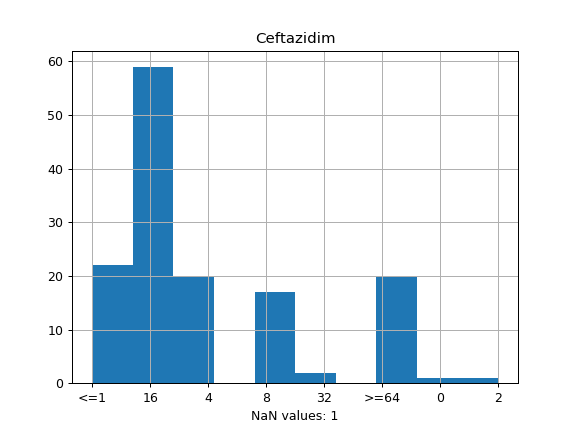

<IPython.core.display.Javascript object>


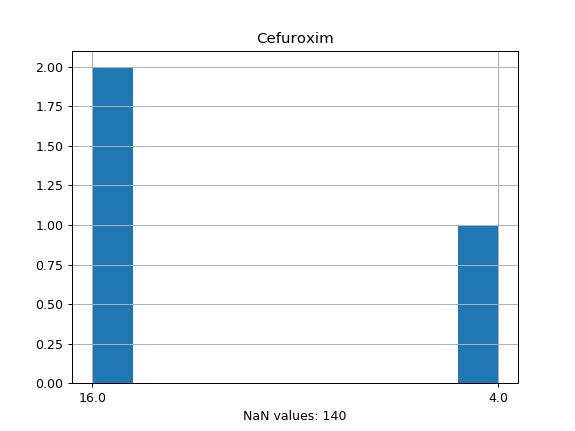

<IPython.core.display.Javascript object>


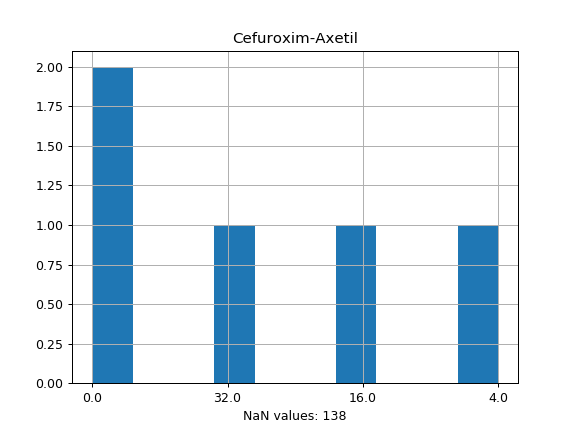

<IPython.core.display.Javascript object>


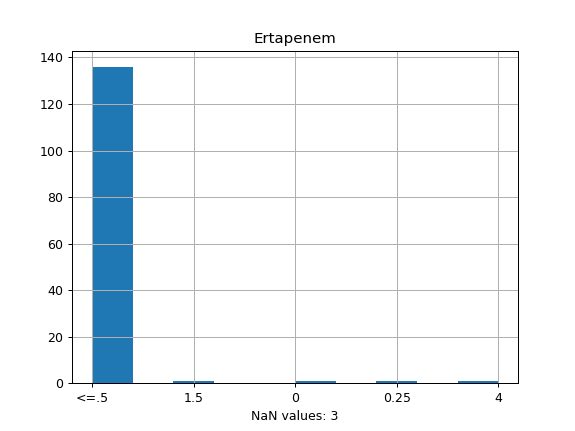

<IPython.core.display.Javascript object>


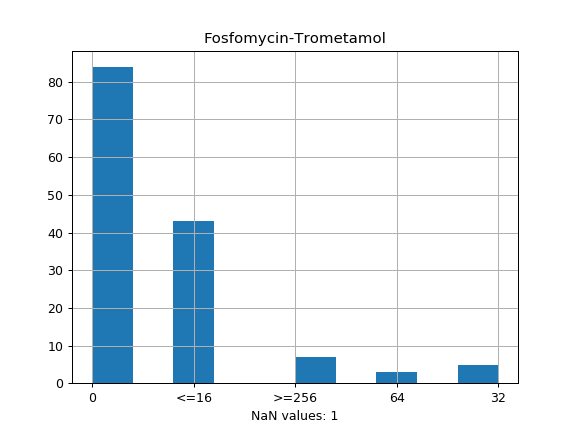

<IPython.core.display.Javascript object>


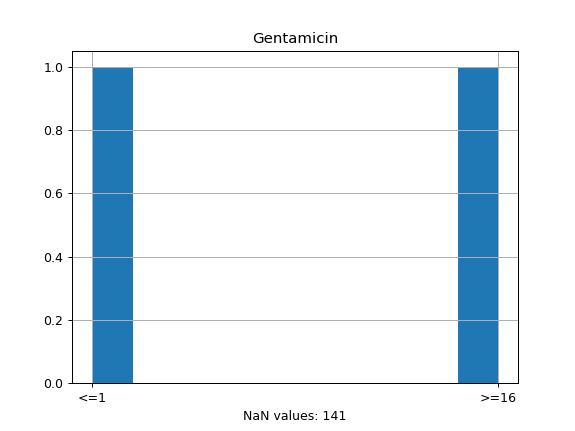

<IPython.core.display.Javascript object>


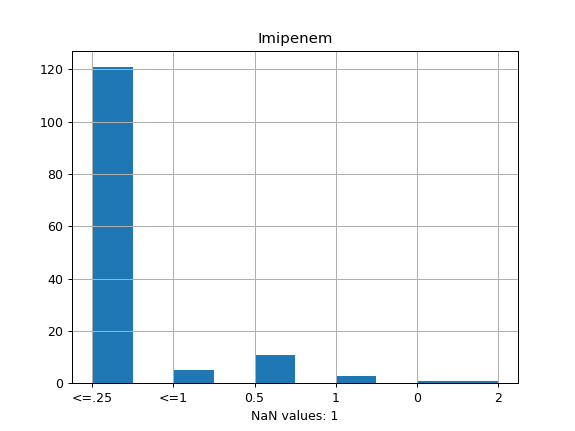

<IPython.core.display.Javascript object>


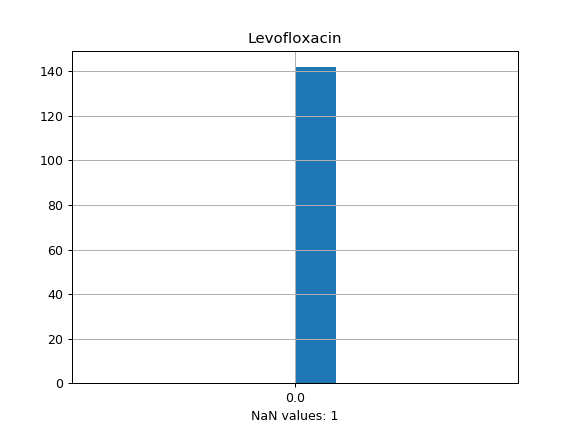

<IPython.core.display.Javascript object>


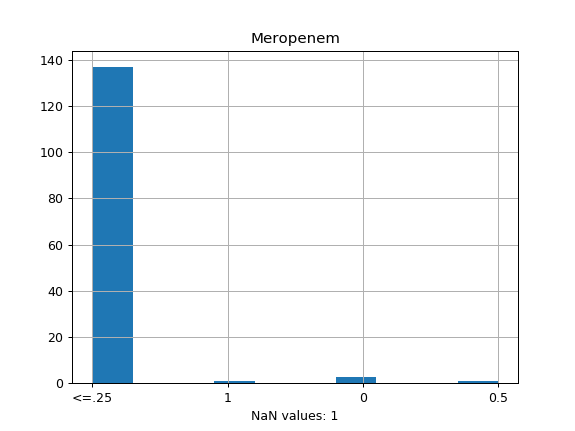

<IPython.core.display.Javascript object>


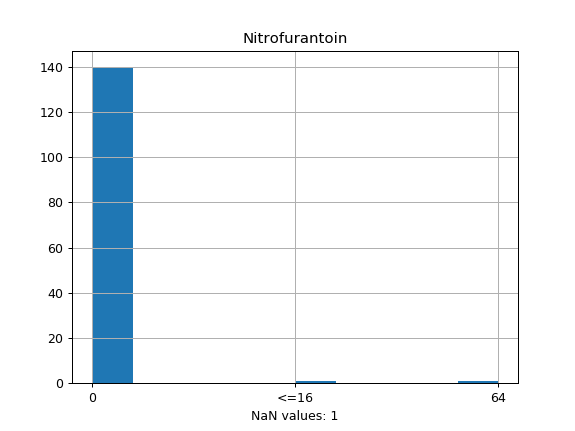

<IPython.core.display.Javascript object>


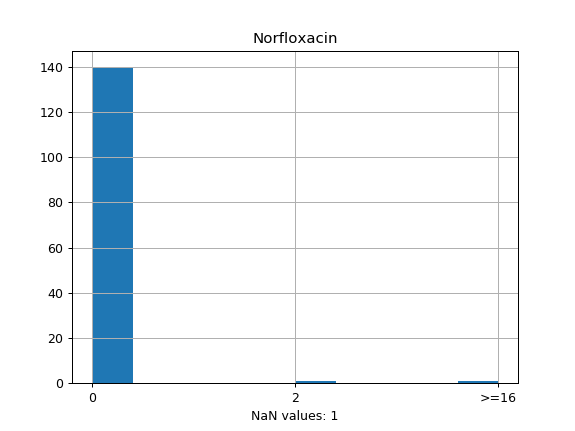

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


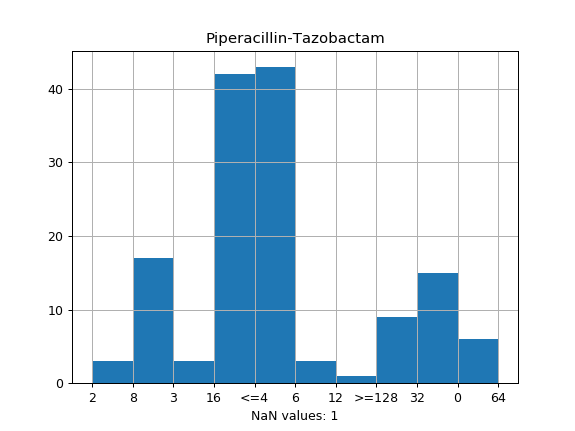

<IPython.core.display.Javascript object>


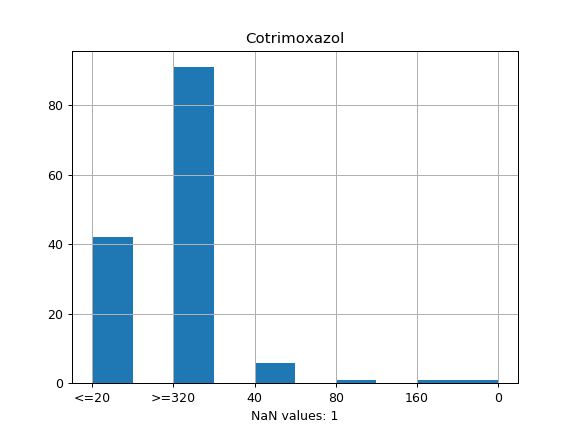

<IPython.core.display.Javascript object>


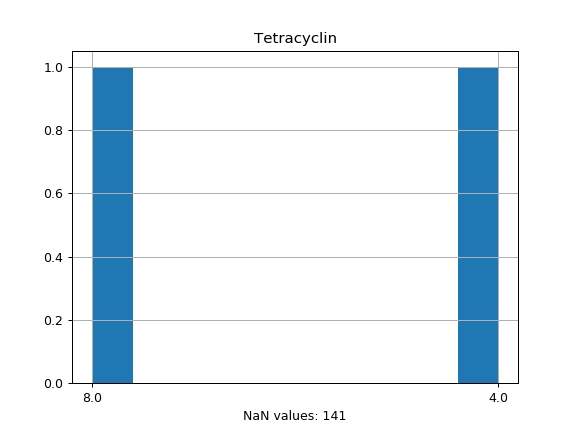

<IPython.core.display.Javascript object>


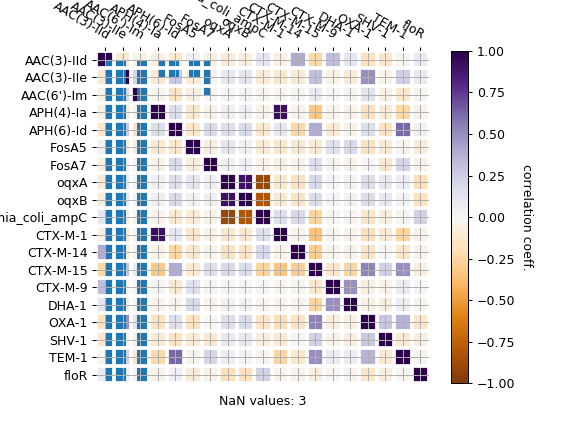

In [18]:
for col in phen.columns[1:]:
    fig = plt.figure()
    phen[col].astype(str).unique()
    phen[col].dropna().astype(str).hist()
    plt.title(col)
    plt.xlabel('NaN values: ' + str(sum(phen[col].isna())))
    plt.show()

In [19]:
for col in phen.columns[1:]:
    print(col, " missing values: ", str(sum(phen[col].isna())))

germ  missing values:  0
Amoxicillin - Clavulanic acid  missing values:  1
Amikacin  missing values:  3
Ampicillin / Amoxicillin  missing values:  1
Cefepime  missing values:  1
Ciprofloxacin  missing values:  1
Cefpodoxim  missing values:  1
Colistin   missing values:  3
Ceftriaxon  missing values:  1
Ceftazidim  missing values:  1
Cefuroxim  missing values:  140
Cefuroxim-Axetil  missing values:  138
Ertapenem  missing values:  3
Fosfomycin-Trometamol  missing values:  1
Gentamicin  missing values:  141
Imipenem  missing values:  1
Levofloxacin  missing values:  1
Meropenem  missing values:  1
Nitrofurantoin  missing values:  1
Norfloxacin  missing values:  1
Piperacillin-Tazobactam  missing values:  1
Cotrimoxazol  missing values:  1
Tetracyclin  missing values:  141
Tobramycin  missing values:  3


In [29]:
phen['germ'].unique()

array(['klevar', 'klepnee', 'klepne', 'kleaer', 'kleoxy', 'kleoxye',
       'kleaere', 'klevare'], dtype=object)

In [30]:
phen['Gentamicin'].unique()

array([nan, '<=1', '>=16'], dtype=object)

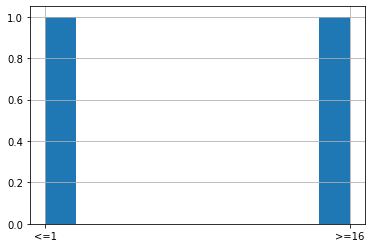

In [32]:
phen['Gentamicin'].hist()

In [31]:
phen['Tetracyclin'].unique()

array([nan,  8.,  4.])

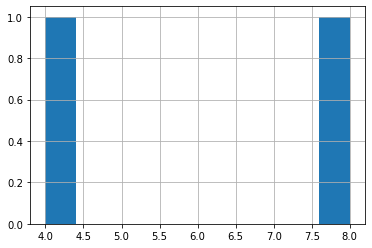

In [33]:
phen['Tetracyclin'].hist()

### gen FULL

In [8]:
gen_full.columns

Index(['#FILE', 'SEQUENCE', 'START', 'END', 'STRAND', 'GENE', 'COVERAGE',
       'COVERAGE_MAP', 'GAPS', '%COVERAGE', '%IDENTITY', 'DATABASE',
       'ACCESSION', 'PRODUCT', 'RESISTANCE'],
      dtype='object')

In [29]:
gen_full[gen_full['%COVERAGE'] > 50][['%COVERAGE', 'COVERAGE', 'COVERAGE_MAP', '%IDENTITY', 'GAPS']].head(20)

,%COVERAGE,COVERAGE,COVERAGE_MAP,%IDENTITY,GAPS
2,96.09,1-369/384,===============,81.30,0/0
3,100.00,1-861/861,===============,100.00,0/0
4,99.03,1-3080/3105,========/======,75.99,5/7
5,85.15,109-1106/1158,.=======/======,73.25,2/12
6,99.91,1-1125/1125,========/======,95.16,7/32
7,100.00,1-363/363,===============,99.17,0/0
8,100.00,1-330/330,===============,99.39,0/0
13,85.85,115-1007/1032,.=======/======,64.33,7/11
14,100.00,1-1749/1749,===============,80.62,0/0
15,83.91,46-1055/1125,========/======,66.15,24/87


In [19]:
gen_full['#FILE'].iloc[76]

'01.rawreads_bgu_1.unicycler/801532-18/assembly.fasta'

# Cleaning

## gen

In [75]:
gen = gen[meaningfull_features]

In [82]:
gen=gen.set_index("Isolate")
meaningfull_features = meaningfull_features[1:]

In [77]:
gen = gen.replace('.', 0)

In [78]:
gen.corr().shape

(19, 19)

In [79]:
gen.corr()

,AAC(3)-IId,AAC(3)-IIe,AAC(6')-Im,APH(4)-Ia,APH(6)-Id,FosA5,FosA7,oqxA,oqxB,Escherichia_coli_ampC,CTX-M-1,CTX-M-14,CTX-M-15,CTX-M-9,DHA-1,OXA-1,SHV-1,TEM-1,floR
AAC(3)-IId,1.000000,-0.115907,-0.032547,-0.057190,-0.125562,0.036098,-0.065182,-0.100690,-0.082384,0.123759,-0.061902,0.406106,-0.227559,0.313689,0.123759,-0.175509,-0.125787,-0.021553,0.079903
AAC(3)-IIe,-0.115907,1.000000,0.215111,-0.116733,0.278181,-0.094164,0.023861,0.106175,0.117490,-0.094624,-0.126350,-0.106175,0.309635,-0.046809,-0.094624,0.497200,-0.039128,0.244663,0.080039
AAC(6')-Im,-0.032547,0.215111,1.000000,-0.024924,-0.148447,-0.069080,-0.028407,0.022670,0.025086,-0.020204,-0.026978,-0.022670,0.079437,-0.009995,-0.020204,0.140078,-0.054819,-0.132321,-0.020204
APH(4)-Ia,-0.057190,-0.116733,-0.024924,1.000000,0.167900,-0.121384,-0.049916,0.039835,0.044080,-0.035501,0.917379,-0.039835,-0.313910,-0.017562,-0.035501,-0.177931,-0.096326,-0.232509,-0.035501
APH(6)-Id,-0.125562,0.278181,-0.148447,0.167900,1.000000,-0.127858,0.191362,0.159259,0.191060,-0.124555,0.113955,-0.237253,0.396710,-0.104598,-0.037670,0.159571,-0.158793,0.632059,0.049215
FosA5,0.036098,-0.094164,-0.069080,-0.121384,-0.127858,1.000000,-0.077475,0.110406,0.038499,-0.098394,-0.131384,-0.110406,-0.101594,0.145388,0.192098,-0.167325,-0.098287,-0.028966,-0.098394
FosA7,-0.065182,0.023861,-0.028407,-0.049916,0.191362,-0.077475,1.000000,0.045401,0.050239,-0.040462,-0.054028,-0.045401,0.159089,-0.020016,-0.040462,0.012865,-0.109787,0.214683,-0.040462
oqxA,-0.100690,0.106175,0.022670,0.039835,0.159259,0.110406,0.045401,1.000000,0.909536,-0.891204,-0.136981,-0.171014,0.203023,0.015974,0.032290,0.161839,0.087614,0.058358,-0.198584
oqxB,-0.082384,0.117490,0.025086,0.044080,0.191060,0.038499,0.050239,0.909536,1.000000,-0.810582,-0.117335,-0.149833,0.165265,0.017676,0.035731,0.178526,0.096951,0.023529,-0.175847
Escherichia_coli_ampC,0.123759,-0.094624,-0.020204,-0.035501,-0.124555,-0.098394,-0.040462,-0.891204,-0.810582,1.000000,0.162204,0.198584,-0.254456,-0.014236,-0.028777,-0.144231,-0.078082,-0.017893,0.228417


In [110]:
gen.head()

,AAC(3)-IId,AAC(3)-IIe,AAC(6')-Im,APH(4)-Ia,APH(6)-Id,FosA5,FosA7,oqxA,oqxB,Escherichia_coli_ampC,CTX-M-1,CTX-M-14,CTX-M-15,CTX-M-9,DHA-1,OXA-1,SHV-1,TEM-1,floR
Isolate,,,,,,,,,,,,,,,,,,,
100548-2-19,0.0,0.0,0,0,0,100.0,0.0,100,100.0,0,0.0,0,0.0,0,0,0,0,0,0
121261-18,0.0,0.0,0,0,100,0.0,0.0,100,100.0,0,0.0,0,100.0,0,0,100,0,100,0
127940-19,0.0,0.0,0,0,0,100.0,0.0,100,100.0,0,0.0,0,0.0,0,0,0,0,0,0
130765-18,0.0,0.0,0,0,0,0.0,0.0,100,100.0,0,0.0,100,0.0,0,0,0,100,0,0
138096-18,0.0,0.0,0,0,100,0.0,0.0,100,100.0,0,0.0,0,100.0,0,0,0,100,0,0


<IPython.core.display.Javascript object>


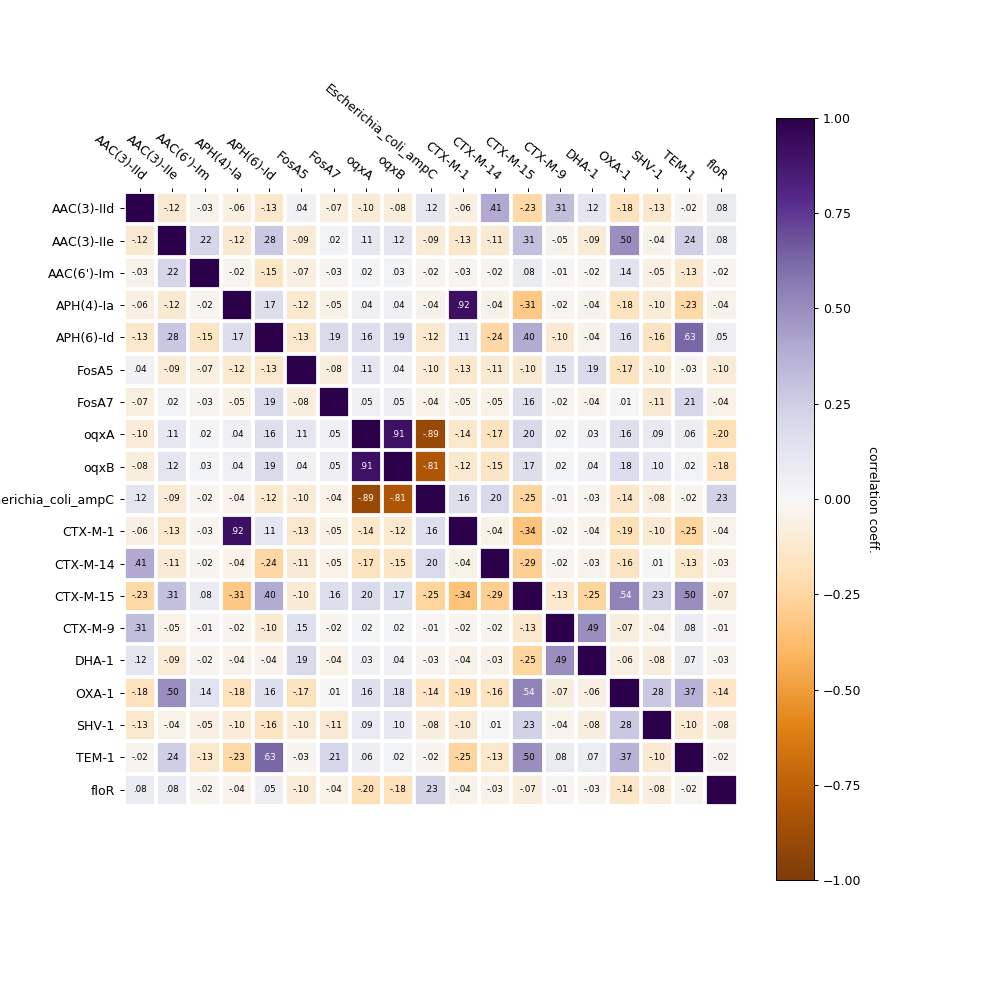

In [109]:
fig = plt.figure(figsize=(11,11))
im, _ = heatmap(gen.corr(), meaningfull_features, meaningfull_features,
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")


def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=7, threshold=0.5)



plt.show()

## phen

In [114]:
phen = phen.set_index("strain")

### Examine one col

In [264]:
values_dict = {
    0     : 1.0,
    '<=2' : 1.0,
    4     : 2.0,
    6     : 3.0,
    8     : 3.0,
    16    : 4.0,
    '>=32': 5.0,
}

final_dict = {
    '<=2' : 1.0,
    4     : 2.0,
    8     : 3.0,
    16    : 4.0,
    '>=32': 5.0,
}

In [265]:
target1 = phen.iloc[:,1]

In [266]:
target1.unique()

array(['<=2', 16, 4, 8, '>=32', 6, 0, nan], dtype=object)

In [267]:
target1 = target1.dropna()

In [268]:
target1.unique()

array(['<=2', 16, 4, 8, '>=32', 6, 0], dtype=object)

In [269]:
for key in values_dict.keys():
    target1 = target1.replace(key, values_dict[key])

In [270]:
target1

strain
100548-2-19       1.0
121261-18         4.0
127940-19         2.0
130765-18         2.0
138096-18         2.0
145605-17         4.0
402121-18         2.0
500122-18         3.0
500888-12         3.0
500965-13         2.0
502451-18         5.0
502839-19         1.0
503158-18         3.0
503171-19         3.0
601529-13         3.0
602149-19         3.0
602723-12         2.0
602822-14         5.0
605997-18         5.0
700207-18         5.0
700607-17         3.0
701520-11         3.0
701615-18         4.0
702603-18         5.0
703613-19         2.0
704193-17         4.0
705349-17         4.0
706120-19         4.0
706143-1-17       4.0
706143-2-17       4.0
706229-18         4.0
706508-16-wh      1.0
706827-19         3.0
706961-11         5.0
706965-17         3.0
708350-18         5.0
708620-18         4.0
709064Mo1-18      5.0
709064Mo2-18      5.0
709064Mo3-18      5.0
709347-19         2.0
709472-19         3.0
709716-17         4.0
711057-17         3.0
712459-19         3.0
712

# Building models

## Playing with Amoxicillin - Clavulanic acid as regression

In [271]:
data = pd.concat([gen, target1], axis=1, join="inner")
data

,AAC(3)-IId,AAC(3)-IIe,AAC(6')-Im,APH(4)-Ia,APH(6)-Id,FosA5,FosA7,oqxA,oqxB,Escherichia_coli_ampC,CTX-M-1,CTX-M-14,CTX-M-15,CTX-M-9,DHA-1,OXA-1,SHV-1,TEM-1,floR,Amoxicillin - Clavulanic acid
100548-2-19,0.00,0.00,0,0,0,100.00,0.00,100,100.00,0,0.0,0,0.00,0,0,0,0,0,0,1.0
121261-18,0.00,0.00,0,0,100,0.00,0.00,100,100.00,0,0.0,0,100.00,0,0,100,0,100,0,4.0
127940-19,0.00,0.00,0,0,0,100.00,0.00,100,100.00,0,0.0,0,0.00,0,0,0,0,0,0,2.0
130765-18,0.00,0.00,0,0,0,0.00,0.00,100,100.00,0,0.0,100,0.00,0,0,0,100,0,0,2.0
138096-18,0.00,0.00,0,0,100,0.00,0.00,100,100.00,0,0.0,0,100.00,0,0,0,100,0,0,2.0
145605-17,0.00,100.00,0,0,100,0.00,0.00,100,100.00,0,0.0,0,100.00,0,0,100,0,100,0,4.0
402121-18,0.00,0.00,0,0,0,100.00,0.00,100,99.24,0,0.0,0,0.00,0,0,0,0,0,0,2.0
500122-18,0.00,0.00,0,0,0,0.00,0.00,100,100.00,0,0.0,0,0.00,0,0,0,0,0,0,3.0
500888-12,0.00,0.00,0,0,0,100.00,0.00,100,100.00,0,0.0,0,0.00,0,0,0,0,0,0,3.0
500965-13,0.00,0.00,0,0,0,0.00,0.00,100,100.00,0,0.0,0,0.00,0,0,0,0,0,0,2.0


In [272]:
data.shape

(142, 20)

In [273]:
X = data.iloc[:, :-1].reset_index().iloc[:,1:].values
y = data.iloc[:, -1].reset_index().iloc[:,1:].values

In [289]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [290]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    print("rounded: ", rounded_predictions)
    print("actual: ", actuals.T[0])
    print(mean_squared_error(actuals, predictions))
    print(confusion_matrix([str(x) for x in actuals.T[0]], [str(x) for x in rounded_predictions]))
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)

[18:05:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rounded:  [3.0, 3.0, 5.0, 3.0, 4.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 5.0, 3.0, 5.0, 5.0]
actual:  [2. 4. 5. 3. 5. 5. 5. 5. 3. 5. 5. 4. 5. 5. 4.]
1.0869333953954954
[[0 1 0 0]
 [0 2 0 0]
 [0 1 0 2]
 [0 3 3 3]]
[18:05:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rounded:  [3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 5.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.0, 3.0]
actual:  [2. 2. 5. 2. 3. 5. 5. 2. 3. 4. 2. 4. 3. 3. 3.]
1.0566934336439886
[[0 3 2 0]
 [0 3 2 0]
 [0 0 2 0]
 [0 2 0 1]]
[18:05:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rounded:  [4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 5.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0]
actual:  [1. 1. 3. 3. 5. 4. 4. 3. 4. 4. 3. 4. 3. 3.]
1.121468486393947
[[0 0 2 0]
 [0 5 1 0]
 [0 2 2 1]
 [0 0 1 0]]
[18:05:33] WARNING: src/objective/regressio

In [291]:
print(mean_squared_error(tot_actuals, tot_predictions))

0.7742366563759465


<IPython.core.display.Javascript object>


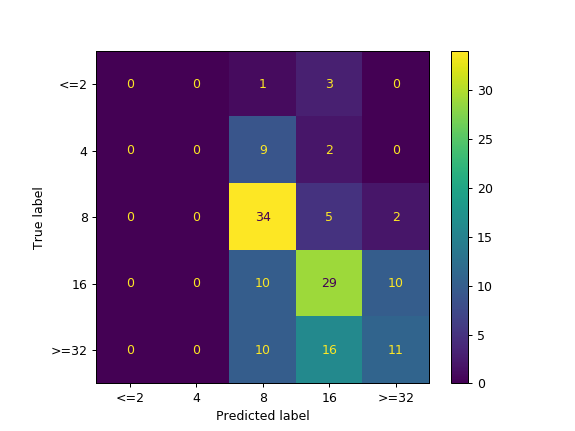

In [292]:
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

### run Parameter Opt

In [319]:
param_grid = {
    'max_depth':[3, 4, 6, 8, 10], 
    'n_estimators': [20, 50, 100, 200],
    'eta': uniform(loc=0, scale=1),
    'gamma': uniform(loc=0, scale=100),
    'min_child_weight': uniform(loc=0, scale=10),
    ''
}

In [320]:
xgb_model = xgb.XGBRegressor(n_jobs=1)

In [321]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [322]:
clf = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=rng, cv = kf)

In [323]:
search = clf.fit(X, y)
search.best_params_
search.best_score_

[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.2719582886878314

[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<IPython.core.display.Javascript object>


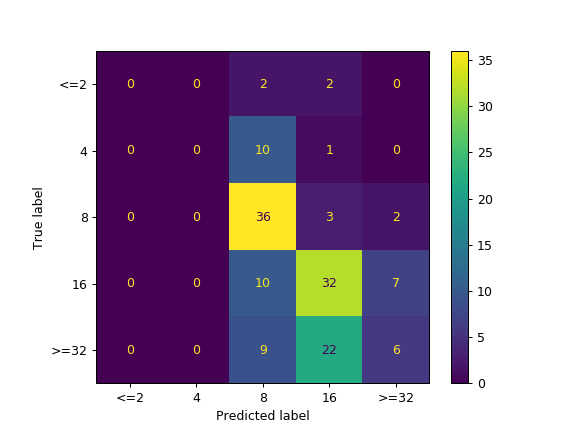

In [324]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, **search.best_params_).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)
    
print(mean_squared_error(tot_actuals, tot_predictions))
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

In [318]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)